# Phase corrected parareal coupling FDTDs
Author: Hieu Nguyen, ICES UT-Austin 2018

Include in this notebook: 
- a sample initial profile and velocity field
- finite difference scheme for periodic 2nd order wave equation
- upsampling and downsampling methods for spatial resolution
- phase corrected parareal, a parallel-in-time iterative method
- numerical result at different parareal iterations

In [1]:
# Use Pkg.update() and Pkg.add() to update and add any missing packages
using PyPlot
using LaTeXStrings

## 1. Initial conditions and velocity profile:

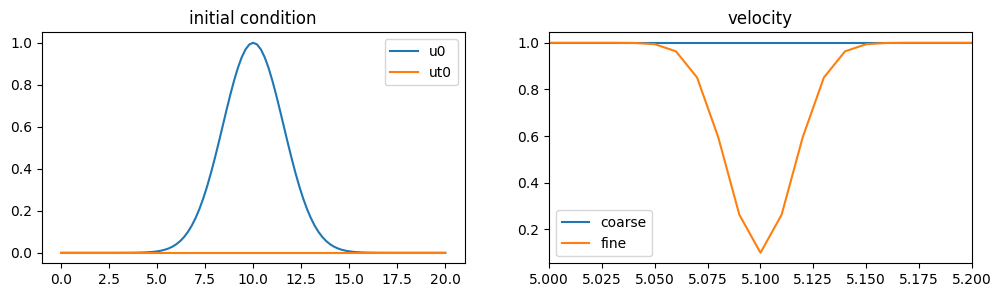

PyObject <matplotlib.legend.Legend object at 0x0000000025123C50>

In [2]:
L = 20.0;
dX = 0.2;
X = collect(0:dX:L);
N = size(X,1);
u0 = exp.(-0.2*(X-0.5*L).^2); # Gaussian 
# k=1;u0=exp.(-im*k*X-0.5*(X-0.5*L).^2); # sinusoidal - Gaussian modulated
ut0 = zeros(N);
m=20; # fine-coarse resolution ratio
dx=dX/m;
x = collect(0:dx:L);
vel=[1-0.9*exp(-2e3*(xx-5.1)^2) for xx in X]; # coarse velocity profile
vel4f=[1-0.9*exp(-2e3*(xx-5.1)^2) for xx in x]; # fine velocity profile

figure(figsize=(12,3))
subplot(1,2,1);plot(X,u0,label="u0");plot(X,ut0,label="ut0");title("initial condition");legend()
subplot(1,2,2);plot(X,vel,label="coarse");plot(x,vel4f,label="fine");title("velocity");xlim([5.0,5.2]);legend()

## 2. Define FDTD scheme - velocity Verlet time stepping with periodic boundary condition:

In [3]:
function fdtd_wave(u0,ut0,dx,vel,t_final)

    c = vel;
    dt = dx/4;    
    N = size(u0,1);
    u = complex(zeros(N));
    ut= complex(zeros(N));
    preu=complex(zeros(N));
    
    u[:] =u0;
    ut[:]=ut0;
    
    B = spdiagm((ones(N-1),-2*ones(N),ones(N-1)), (-1,0,1))/dx^2;
    B[1,N] = 1.0/dx^2;
    B[N,1] = 1.0/dx^2;
    
    wfd(y,yt) = y + yt*dt + 0.5*dt^2*c.^2.*(B*y);
    
    for t = 1:Int(floor(t_final/dt)) # velocity verlet time stepping
        preu[:]=u;
        u = wfd(u,ut);
        ut= ut+0.5*dt*c.^2.*(B*preu+B*u);
    end
    
    return (u,ut)

end

fdtd_wave (generic function with 1 method)

## 3. Define Fourier upsampling and downsampling functions

In [4]:
function fourierinterp(a,m) # padding zeros to higher frequency modes
    N=size(a,1);
    aff = fft(a);
    return ifft([aff[1:Int(floor(N/2))];complex(zeros((m-1)*(N-1)));aff[Int(floor(N/2))+1:end]])*((N-1)*m+1)/N;
end

function fouriersamp(a,m) # removing higher frequency mode components
    N=size(a,1);
    aff = fft(a);
    st=Int(floor(N/(2*m)))
    en=N-Int(floor(N/(2*m)))
    return ifft([aff[1:st];aff[en:end]])*((N-1)/m+1)/(N);
end

fouriersamp (generic function with 1 method)

## 4. Phase corrected parareal scheme
Use above fdtd and sampling functions to do parareal coupling of coarse and fine spatial grid size

In [5]:
function wave1dparareal(u0,ut0,dX,vel,m,vel4f,pimax)
    t_final = 100;
    dT = 1;
    time = collect(0:dT:t_final);
    Nt = size(time,1);
    Nx = size(u0,1);
    
    u  = complex(zeros(Nx,Nt));
    ut = complex(zeros(Nx,Nt));
    
    u[:,1]  = u0[:];
    ut[:,1] = ut0[:];
    
    dx = dX/m;
    
    for i=2:Nt  # initial parareal initialization
        u[:,i],ut[:,i]=fdtd_wave(u[:,i-1],ut[:,i-1],dX,vel,dT);
    end
    
    finesol = complex(zeros(Nx,Nt));
    finesolt = complex(zeros(Nx,Nt));
    coarsesol= complex(zeros(Nx,Nt));
    coarsesolt= complex(zeros(Nx,Nt));
    
    ffsol = complex(zeros((Nx-1)*m+1,Nt));
    ffsolt= complex(zeros((Nx-1)*m+1,Nt));

    phase_crter=complex(ones(Nx,Nt));
    phaset_crter=complex(ones(Nx,Nt));
    
    for pri=1:pimax # parareal iteration
        
        for i=2:Nt # PARALLEL COMPUTATION
            ffmode =ffsol[:,i-1] - fourierinterp(fouriersamp(ffsol[:,i-1],m),m); 
            ffmodet=ffsolt[:,i-1] - fourierinterp(fouriersamp(ffsolt[:,i-1],m),m);
            
            
            u4f = fourierinterp(u[:,i-1],m)+ffmode;            
            ut4f = fourierinterp(ut[:,i-1],m)+ffmodet;
            
            ffsol[:,i],ffsolt[:,i] = fdtd_wave(u4f,ut4f,dx,vel4f,dT);
            
            finesol[:,i]  = fouriersamp(ffsol[:,i],m);         
            finesolt[:,i]  = fouriersamp(ffsolt[:,i],m);   
            
            coarsesol[:,i],coarsesolt[:,i] = fdtd_wave(u[:,i-1],ut[:,i-1],dX,vel,dT);       
        end
        
        g_ft=complex(ones(Nx,Nt));
        gt_ft=complex(ones(Nx,Nt));
        
        ffine=fft(finesol,1);
        ffinet=fft(finesolt,1);
        for i=pri:Nt # phase difference computation

            fcoarse=conj(phase_crter[:,i]).*fft(coarsesol[:,i]);
            fcoarset=conj(phaset_crter[:,i]).*fft(coarsesolt[:,i]);
                    
            alpha=exp.(im*angle.(fcoarse.*conj(ffine[:,i])));            
            betaa=exp.(im*angle.(fcoarset.*conj(ffinet[:,i])));
            g_ft[:,i]=alpha;
            gt_ft[:,i]=betaa;                     
        end
        
        kern=[exp(-(s/1e2)^2) for s in linspace(-Nt/2,Nt/2,Nt)];
        
        for j=1:Nx # average phase
            g_ft[j,:] =ifft(fft(kern/sum(kern)).*fft(g_ft[j,:]));
            gt_ft[j,:]=ifft(fft(kern/sum(kern)).*fft(gt_ft[j,:]));
        end
        phase_crter=phase_crter.*g_ft;
        phaset_crter=phaset_crter.*gt_ft;         
        
        for i=2:Nt # SEQUENTIAL COMPUTATION
            us,uts=fdtd_wave(u[:,i-1],ut[:,i-1],dX,vel,dT);
            fus=fft(us);
            futs=fft(uts);
            fcoarse=fft(coarsesol[:,i]);
            fcoarset=fft(coarsesolt[:,i]);
            
            u[:,i]=ifft(conj(phase_crter[:,i]).*(fus-fcoarse))+finesol[:,i];
            ut[:,i]=ifft(conj(phase_crter[:,i]).*(futs-fcoarset))+finesolt[:,i];               
            
        end    
        
        if(mod(pri,5)==0) # monitor iteration
            println("k=",pri)
        end
        
    end    
    
    return (u,ut,phase_crter,phaset_crter)
    
end

wave1dparareal (generic function with 1 method)

**compute coarse initial parareal guess**

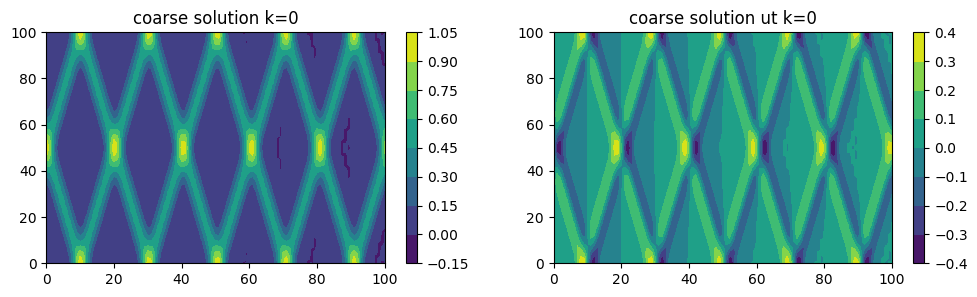

PyObject <matplotlib.colorbar.Colorbar object at 0x00000000301229B0>

In [6]:
u1,ut1=wave1dparareal(u0,ut0,dX,vel,1,vel4f,0);
figure(figsize=(12,3))
subplot(1,2,1)
contourf(u1);title("coarse solution k=0")
colorbar()

subplot(1,2,2)
contourf(ut1);title("coarse solution ut k=0")
colorbar()

**compute full fine scale (exact) solution**

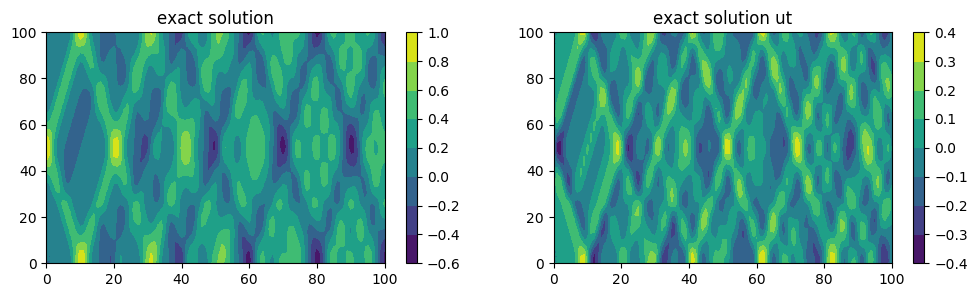

PyObject <matplotlib.colorbar.Colorbar object at 0x00000000308B00B8>

In [7]:
u4f = fourierinterp(u0,m);
ut4f = fourierinterp(ut0,m);

ub,utb=wave1dparareal(u4f,ut4f,dx,vel4f,1,vel4f,0);

ubdown = complex(zeros(N,size(ub,2)))
utbdown = complex(zeros(N,size(utb,2)))

for i=1:size(ub,2)   
    ubdown[:,i]  = fouriersamp(ub[:,i],m)
    utbdown[:,i]  = fouriersamp(utb[:,i],m)  
end

figure(figsize=(12,3))
subplot(1,2,1)
contourf(ubdown);title("exact solution")
colorbar()
subplot(1,2,2)
contourf(utbdown);title("exact solution ut")
colorbar()

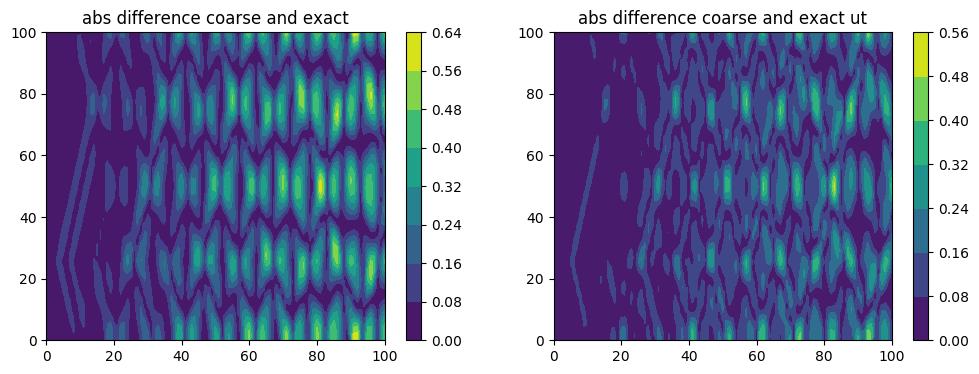

PyObject <matplotlib.colorbar.Colorbar object at 0x0000000036297DD8>

In [8]:
figure(figsize=(12,4));
subplot(1,2,1);contourf(abs.(u1-ubdown));title("abs difference coarse and exact")
colorbar()
subplot(1,2,2);contourf(abs.(ut1-utbdown));;title("abs difference coarse and exact ut")
colorbar()

## 5. Numerics 
This will take about 15 mins to finish

In [9]:
u2,ut2,cg2,cgt2=wave1dparareal(u0,ut0,dX,vel,m,vel4f,1);
u3,ut3,cg3,cgt3=wave1dparareal(u0,ut0,dX,vel,m,vel4f,5);
u4,ut4,cg4,cgt4=wave1dparareal(u0,ut0,dX,vel,m,vel4f,10);
u5,ut5,cg5,cgt5=wave1dparareal(u0,ut0,dX,vel,m,vel4f,20);

k=5
k=5
k=10
k=5
k=10
k=15
k=20


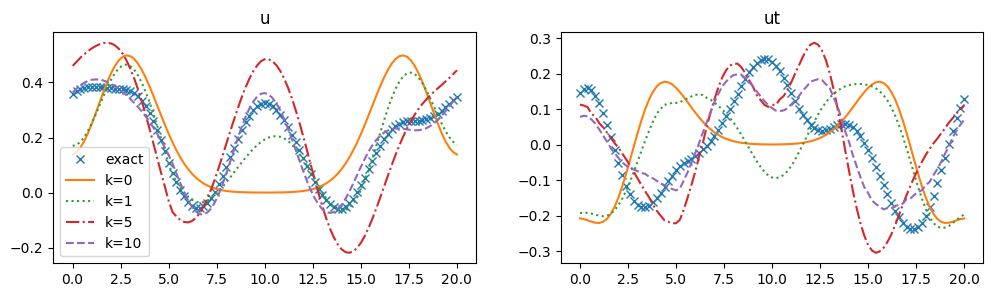

PyObject <matplotlib.text.Text object at 0x0000000036663A90>

In [10]:
tsamp=95;
figure(figsize=(12,3))
subplot(1,2,1)
plot(X,ubdown[:,tsamp],linestyle="",marker="x",label="exact")
plot(X,u1[:,tsamp],label="k=0")
plot(X,u2[:,tsamp],linestyle=":",label="k=1")
plot(X,u3[:,tsamp],linestyle="-.",label="k=5")
plot(X,u4[:,tsamp],linestyle="--",label="k=10")
title("u")
legend()

subplot(1,2,2)
plot(X,utbdown[:,tsamp],linestyle="",marker="x",label="exact")
plot(X,ut1[:,tsamp],label="k=0")
plot(X,ut2[:,tsamp],linestyle=":",label="k=1")
plot(X,ut3[:,tsamp],linestyle="-.",label="k=5")
plot(X,ut4[:,tsamp],linestyle="--",label="k=10")
title("ut")

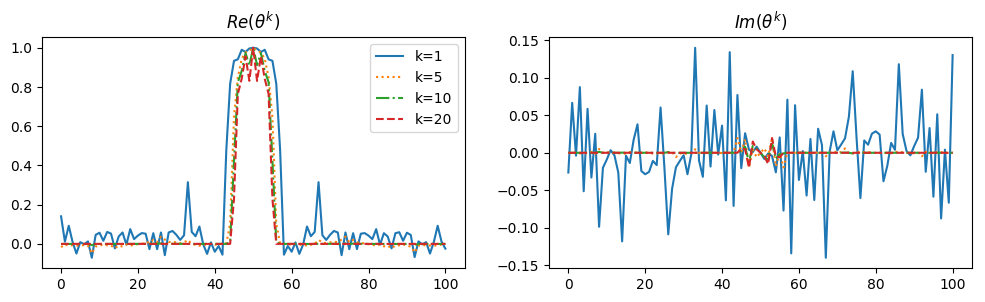

PyObject <matplotlib.text.Text object at 0x0000000036A69908>

In [11]:
figure(figsize=(12,3))
subplot(1,2,1)
plot(fftshift(cg2[:,end]),label="k=1")
plot(fftshift(cg3[:,end]),linestyle=":",label="k=5")
plot(fftshift(cg4[:,end]),linestyle="-.",label="k=10")
plot(fftshift(cg5[:,end]),linestyle="--",label="k=20")
legend()
title(L"Re(\theta^k)")

subplot(1,2,2)
plot(fftshift(imag.(cg2[:,end])),label="k=1")
plot(fftshift(imag.(cg3[:,end])),linestyle=":",label="k=5")
plot(fftshift(imag.(cg4[:,end])),linestyle="-.",label="k=10")
plot(fftshift(imag.(cg5[:,end])),linestyle="--",label="k=20")
title(L"Im(\theta^k)")

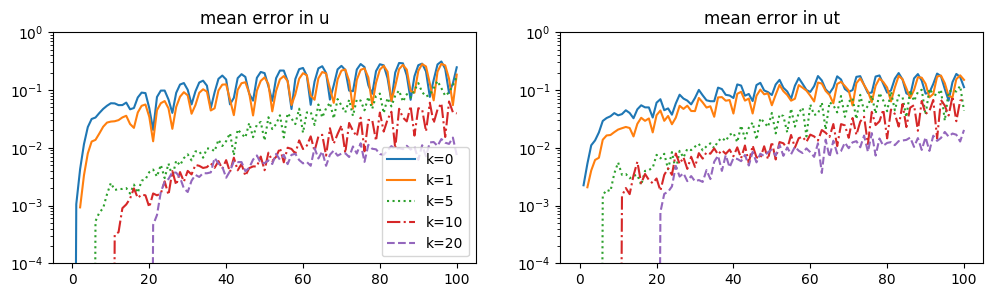

PyObject <matplotlib.text.Text object at 0x0000000037758438>

In [12]:
figure(figsize=(12,3))
subplot(1,2,1);
semilogy(mean(abs.(u1-ubdown),1).',label="k=0")
semilogy(mean(abs.(u2-ubdown),1).',label="k=1")
semilogy(mean(abs.(u3-ubdown),1).',linestyle=":",label="k=5")
semilogy(mean(abs.(u4-ubdown),1).',linestyle="-.",label="k=10")
semilogy(mean(abs.(u5-ubdown),1).',linestyle="--",label="k=20")
ylim([1e-4,1e0]);
legend()
title("mean error in u")

subplot(1,2,2);
semilogy(mean(abs.(ut1-utbdown),1).')
semilogy(mean(abs.(ut2-utbdown),1).')
semilogy(mean(abs.(ut3-utbdown),1).',linestyle=":")
semilogy(mean(abs.(ut4-utbdown),1).',linestyle="-.")
semilogy(mean(abs.(ut5-utbdown),1).',linestyle="--")
ylim([1e-4,1e0]);
title("mean error in ut")

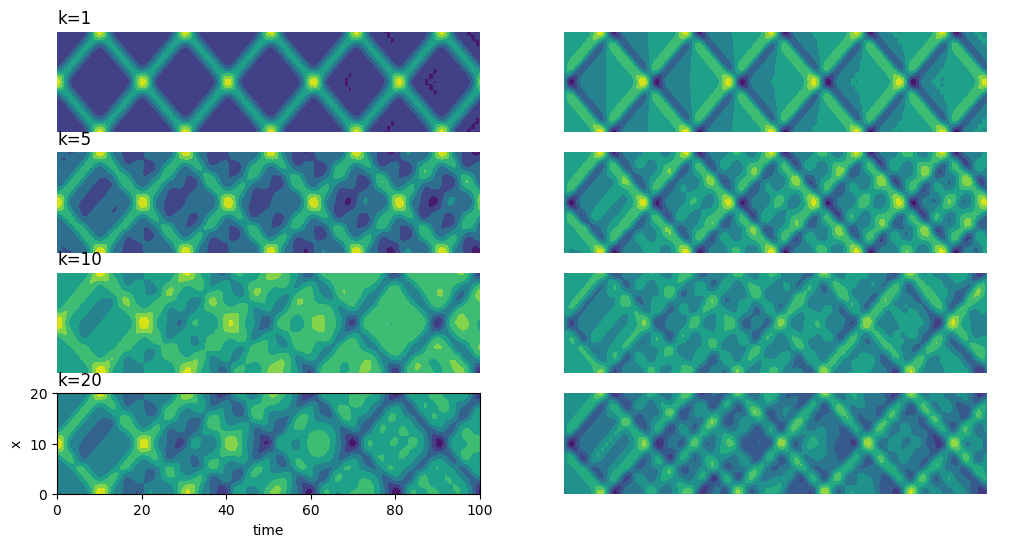

In [13]:
figure(figsize=(12,6))
subplot(4,2,1);
contourf(u1);axis("off");title("k=1",loc="left")
subplot(4,2,2);
contourf(ut1);axis("off")
subplot(4,2,3);
contourf(u2);axis("off");title("k=5",loc="left")
subplot(4,2,4);
contourf(ut2);axis("off")
subplot(4,2,5);
contourf(u3);axis("off");title("k=10",loc="left")
subplot(4,2,6);
contourf(ut3);axis("off")
subplot(4,2,7);
contourf(collect(0:1:100),X,u4);title("k=20",loc="left");xlabel("time");ylabel("x")
subplot(4,2,8);
contourf(ut4);axis("off");
#savefig("hetero1d_evol.eps")